# MCMC integration test

Here, we'll test performance of the nGP model on sample data.

In [1]:
import numpy as np
import ngptools as ngp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

np.random.seed(12355)  # set random seed

### Load data

In [ ]:
data = np.loadtxt('data/blocks_sampled.csv', delimiter=',')
tobs = data[:, 0]
y = data[:, 1]
Nt = y.size

### Define some useful variables

In [8]:
delta = np.diff(np.concatenate([tobs, [1.1]]))
Np, Nm, Nr = 1, 3, 3
dims = Np, Nm, Nr

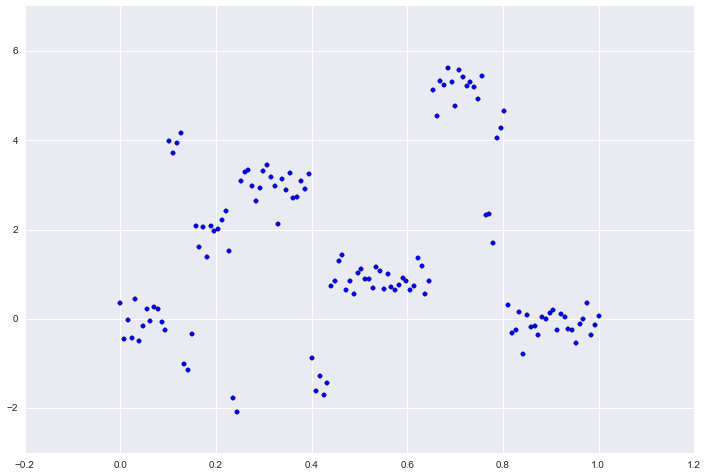

In [3]:
plt.figure(figsize=(12, 8))
plt.scatter(tobs, y)
pass

## Pick priors and starting values for parameters

In [4]:
sigU = 5.
sigA = 5.
sigeps = 2.
sigmu = 4.
sigalpha = 4.
a, b = 1., 1.

## Algorithm

The algorithm is as follows:

1. Given the various $\sigma^2$ parameters, perform an exact draw from the posterior for the state vector 
    $(U, DU, A)$.
1. Given the state vector, draw
    $$
    \sigma^2_\epsilon \sim \text{inv-Ga}\left( 
    a + \frac{N_t}{2},
    b + \frac{1}{2} \sum_t (y_t - U(t))^2
    \right)
    $$
1. Sample $\sigma^2_U$ and $\sigma^2_A$:

    1. Draw a sample of the state vector, $(U^*, DU^*, A^*)$, from the approximate model.
    1. Conditioned on this approximate state vector, sample proposed variance parameters as
        $$\begin{align}
        \sigma^2 &\sim \text{inv-Ga}\left(a + \frac{N_t}{2}, b + \frac{1}{2} R^2 \right) \\
        R^2_U &= \sum_j \delta_j \left[\frac{DU^*(t_{j+1}) - DU^*(t_j)}{\delta_j} - A^*(t_j) \right]^2 \\
        R^2_A &= \sum_j \left[\frac{(A^*(t_{j+1}) - A^*(t_j))^2}{\delta_j}\right]
        \end{align}$$
    1. Accept these proposals with probability $\mathrm{min}(\pi, 1)$ with
        $$
        \pi \equiv \prod_j \frac{\mathcal{N}(\theta_{j + 1} - G_j\theta_j|0, W^*_j)}
        {\mathcal{N}(\theta_{j + 1} - G_j\theta_j|0, W_j)}
        \frac{\mathcal{N}(\tilde{H}^\top (\theta^*_{j + 1} - G_j\theta^*_j)|0, \tilde{W}_j)}
        {\mathcal{N}(\tilde{H}^\top (\theta^*_{j + 1} - G_j\theta^*_j)|0, \tilde{W}^*_j)}
        $$
        (Think of this like $\frac{P(x')}{P(x)}\frac{g(x)}{g(x')}$, with $P$ the posterior and $g$ the proposal 
        distribution, and recall that what we are proposing is $\sigma^2|\theta^*$).

### Useful functions:

In [9]:
def draw_state(sigeps, sigU, sigA, approx=False):
    return npg.sample(y, 1, dims, delta, sigeps, sigU, sigA, sigmu, sigalpha, approx)

In [10]:
def draw_sig_eps(U):
    a_eff = a + (Nt / 2)
    b_eff = b + 0.5 * np.sum((y - U)**2)
    return stats.invgamma.rvs(a=a_eff, scale=b_eff)